# CNN_3channel_InceptionV3_FineTune

Abstract:
- single channel: band_avg
- CNN, small net

Result:
- 增大网络的各个参数，只是把train数据的拟合程度增加了（到了99%），而cv数据的泛化能力仍然只有87%，说明，特征还需要进一步的提取来增加系统的泛化能力。

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [3]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

import gc

### Run name

In [4]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_InceptionV3_FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180110_083957


### Folder Pathes

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\statoil-iceberg-classifier-challenge\input
log_path: D:\Kaggle\statoil-iceberg-classifier-challenge\log
model_path: D:\Kaggle\statoil-iceberg-classifier-challenge\model
output_path: D:\Kaggle\statoil-iceberg-classifier-challenge\output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Basic functions

In [7]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [8]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [9]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
y_data = pickle.load(open(is_iceberg_path, mode='rb'))
describe(y_data)

(1604,) 0 1 12936


In [10]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

describe(inc_angle_data)
describe(inc_angle_test)

(1604,) 0.0 45.9375 12936
(8424,) 23.0805 50.66178518 67496
Wall time: 8 ms


In [36]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data_gray.p')
band2_data_path = os.path.join(input_path, 'band2_data_gray.p')
band1_test_path = os.path.join(input_path, 'band1_test_gray.p')
band2_test_path = os.path.join(input_path, 'band2_test_gray.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
Wall time: 1.56 s


In [12]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 75, 75) 0.0 0.979400825264 72180128
(8424, 75, 75) 0.0 0.930272493331 379080128
(1604, 75, 75) 0.0 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
(1604, 75, 75) 0.0210369138693 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.55 s


In [13]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 75, 75) 0.0 0.979400825264 72180128
(8424, 75, 75) 0.0 0.930272493331 379080128
(1604, 75, 75) 0.0 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
(1604, 75, 75) 0.0210369138693 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.71 s


In [14]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_max_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
# del band1_data
# del band2_data
# del band_avg_data
gc.collect()

x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_max_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
# del band1_test
# del band2_test
# del band_avg_test
gc.collect()

(1604, 75, 75, 3) 0.0 1.0 216540144
(8424, 75, 75, 3) 0.0 1.0 1137240144
Wall time: 1.24 s


In [15]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.1, random_state=31)
describe(x_train)
describe(x_val)
describe(inc_angle_train)
describe(inc_angle_val)
describe(y_train)
describe(y_val)

(1443, 75, 75, 3) 0.0 1.0 194805144
(161, 75, 75, 3) 0.0 1.0 21735144
(1443,) 0.0 45.9375 23112
(161,) 0.0 45.2814 2600
(1443,) 0 1 23112
(161,) 0 1 2600
Wall time: 170 ms


## 2. Build model

In [16]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19, preprocess_input

Using TensorFlow backend.


In [17]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [20]:
def get_lr(x):
    lr = round(1e-4 * 0.995 ** x, 6)
    if lr < 1e-5:
        lr = 1e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\statoil-iceberg-classifier-challenge\log\SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_001749


In [21]:
datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [22]:
%%time
batch_size = 8
# steps_per_epoch = 1 * len(x_train) / batch_size
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, seed=2019),
    steps_per_epoch=100,
    epochs=1000, #1 for ETA, 0 for silent
    verbose=1,
    max_queue_size=128,
    callbacks=[annealer],
    workers=32,
    validation_data=(x_val, y_val)
)

0.0001  Epoch 1/1000
100/100 [==============================] - 23s 232ms/step - loss: 0.6888 - acc: 0.5387 - val_loss: 0.6624 - val_acc: 0.6894
0.0001  Epoch 2/1000
100/100 [==============================] - 21s 213ms/step - loss: 0.6627 - acc: 0.6029 - val_loss: 0.6377 - val_acc: 0.6832
9.9e-05  Epoch 3/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.6512 - acc: 0.6062 - val_loss: 0.6037 - val_acc: 0.6708
9.9e-05  Epoch 4/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.6270 - acc: 0.6525 - val_loss: 0.5880 - val_acc: 0.6646
9.8e-05  Epoch 5/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.6253 - acc: 0.6600 - val_loss: 0.5679 - val_acc: 0.6894
9.8e-05  Epoch 6/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.6222 - acc: 0.6562 - val_loss: 0.5633 - val_acc: 0.6894
9.7e-05  Epoch 7/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.5732 - acc: 0.6975 - val_loss: 0.543

7.6e-05  Epoch 57/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4652 - acc: 0.7571 - val_loss: 0.3892 - val_acc: 0.8012
7.5e-05  Epoch 58/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4656 - acc: 0.7662 - val_loss: 0.3860 - val_acc: 0.8075
7.5e-05  Epoch 59/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4727 - acc: 0.7675 - val_loss: 0.3912 - val_acc: 0.7950
7.4e-05  Epoch 60/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4651 - acc: 0.7354 - val_loss: 0.3916 - val_acc: 0.7826
7.4e-05  Epoch 61/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4642 - acc: 0.7637 - val_loss: 0.3913 - val_acc: 0.8012
7.4e-05  Epoch 62/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4857 - acc: 0.7588 - val_loss: 0.3866 - val_acc: 0.8012
7.3e-05  Epoch 63/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4612 - acc: 0.7559 - val_lo

5.7e-05  Epoch 113/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4470 - acc: 0.7500 - val_loss: 0.3595 - val_acc: 0.8199
5.7e-05  Epoch 114/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4286 - acc: 0.7875 - val_loss: 0.3531 - val_acc: 0.8199
5.6e-05  Epoch 115/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4183 - acc: 0.7863 - val_loss: 0.3546 - val_acc: 0.8199
5.6e-05  Epoch 116/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4524 - acc: 0.7542 - val_loss: 0.3540 - val_acc: 0.8199
5.6e-05  Epoch 117/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4485 - acc: 0.7850 - val_loss: 0.3568 - val_acc: 0.7888
5.6e-05  Epoch 118/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4292 - acc: 0.7675 - val_loss: 0.3543 - val_acc: 0.8261
5.5e-05  Epoch 119/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4204 - acc: 0.7817 -

100/100 [==============================] - 21s 208ms/step - loss: 0.3997 - acc: 0.8200 - val_loss: 0.3394 - val_acc: 0.8012
3.3e-05  Epoch 224/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4120 - acc: 0.7900 - val_loss: 0.3451 - val_acc: 0.8199
3.3e-05  Epoch 225/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4242 - acc: 0.7825 - val_loss: 0.3430 - val_acc: 0.8137
3.2e-05  Epoch 226/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4477 - acc: 0.7588 - val_loss: 0.3455 - val_acc: 0.8012
3.2e-05  Epoch 227/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4098 - acc: 0.7925 - val_loss: 0.3579 - val_acc: 0.8075
3.2e-05  Epoch 228/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4230 - acc: 0.8042 - val_loss: 0.3525 - val_acc: 0.8137
3.2e-05  Epoch 229/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4412 - acc: 0.7692 - val_loss: 0.3529 - val_

100/100 [==============================] - 21s 206ms/step - loss: 0.4251 - acc: 0.7837 - val_loss: 0.3445 - val_acc: 0.8075
1.9e-05  Epoch 334/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4306 - acc: 0.7900 - val_loss: 0.3487 - val_acc: 0.8012
1.9e-05  Epoch 335/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.3911 - acc: 0.8025 - val_loss: 0.3452 - val_acc: 0.8012
1.9e-05  Epoch 336/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4102 - acc: 0.7929 - val_loss: 0.3468 - val_acc: 0.8075
1.9e-05  Epoch 337/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4086 - acc: 0.7925 - val_loss: 0.3404 - val_acc: 0.8012
1.8e-05  Epoch 338/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4399 - acc: 0.7687 - val_loss: 0.3440 - val_acc: 0.8137
1.8e-05  Epoch 339/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4117 - acc: 0.7954 - val_loss: 0.3489 - val_

100/100 [==============================] - 20s 205ms/step - loss: 0.4358 - acc: 0.7987 - val_loss: 0.3416 - val_acc: 0.7950
1.1e-05  Epoch 444/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.3721 - acc: 0.8137 - val_loss: 0.3412 - val_acc: 0.7950
1.1e-05  Epoch 445/1000
100/100 [==============================] - 20s 205ms/step - loss: 0.4163 - acc: 0.8000 - val_loss: 0.3478 - val_acc: 0.7888
1.1e-05  Epoch 446/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.3884 - acc: 0.8037 - val_loss: 0.3382 - val_acc: 0.7888
1.1e-05  Epoch 447/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4010 - acc: 0.7987 - val_loss: 0.3373 - val_acc: 0.7826
1.1e-05  Epoch 448/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.3728 - acc: 0.8037 - val_loss: 0.3424 - val_acc: 0.7950
1.1e-05  Epoch 449/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4061 - acc: 0.8025 - val_loss: 0.3386 - val_

100/100 [==============================] - 21s 205ms/step - loss: 0.3832 - acc: 0.8063 - val_loss: 0.3403 - val_acc: 0.7826
1e-05  Epoch 556/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4147 - acc: 0.7987 - val_loss: 0.3483 - val_acc: 0.7888
1e-05  Epoch 557/1000
100/100 [==============================] - 20s 205ms/step - loss: 0.4023 - acc: 0.7950 - val_loss: 0.3404 - val_acc: 0.7950
1e-05  Epoch 558/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4190 - acc: 0.7971 - val_loss: 0.3487 - val_acc: 0.8012
1e-05  Epoch 559/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.3872 - acc: 0.8025 - val_loss: 0.3428 - val_acc: 0.7826
1e-05  Epoch 560/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.3910 - acc: 0.8050 - val_loss: 0.3426 - val_acc: 0.7888
1e-05  Epoch 561/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4091 - acc: 0.7979 - val_loss: 0.3484 - val_acc: 0.7888


100/100 [==============================] - 21s 207ms/step - loss: 0.4021 - acc: 0.7963 - val_loss: 0.3403 - val_acc: 0.7950
1e-05  Epoch 668/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.3935 - acc: 0.8337 - val_loss: 0.3405 - val_acc: 0.8012
1e-05  Epoch 669/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.3984 - acc: 0.8175 - val_loss: 0.3415 - val_acc: 0.7950
1e-05  Epoch 670/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4046 - acc: 0.7892 - val_loss: 0.3420 - val_acc: 0.8012
1e-05  Epoch 671/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.3912 - acc: 0.8054 - val_loss: 0.3421 - val_acc: 0.7950
1e-05  Epoch 672/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4453 - acc: 0.7700 - val_loss: 0.3455 - val_acc: 0.8075
1e-05  Epoch 673/1000
100/100 [==============================] - 21s 205ms/step - loss: 0.4026 - acc: 0.8037 - val_loss: 0.3465 - val_acc: 0.8075


100/100 [==============================] - 21s 208ms/step - loss: 0.4039 - acc: 0.8004 - val_loss: 0.3455 - val_acc: 0.8012
1e-05  Epoch 780/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.3864 - acc: 0.8187 - val_loss: 0.3448 - val_acc: 0.8075
1e-05  Epoch 781/1000
100/100 [==============================] - 21s 209ms/step - loss: 0.4032 - acc: 0.8012 - val_loss: 0.3412 - val_acc: 0.7950
1e-05  Epoch 782/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.3933 - acc: 0.8009 - val_loss: 0.3422 - val_acc: 0.8012
1e-05  Epoch 783/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.3682 - acc: 0.8200 - val_loss: 0.3419 - val_acc: 0.8012
1e-05  Epoch 784/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.3878 - acc: 0.8092 - val_loss: 0.3378 - val_acc: 0.8075
1e-05  Epoch 785/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.3857 - acc: 0.8179 - val_loss: 0.3366 - val_acc: 0.8075


100/100 [==============================] - 21s 208ms/step - loss: 0.4081 - acc: 0.7887 - val_loss: 0.3558 - val_acc: 0.7950
1e-05  Epoch 892/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.3821 - acc: 0.8150 - val_loss: 0.3439 - val_acc: 0.8012
1e-05  Epoch 893/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.3810 - acc: 0.8129 - val_loss: 0.3449 - val_acc: 0.8137
1e-05  Epoch 894/1000
100/100 [==============================] - 21s 206ms/step - loss: 0.4021 - acc: 0.8037 - val_loss: 0.3473 - val_acc: 0.8075
1e-05  Epoch 895/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4009 - acc: 0.7975 - val_loss: 0.3475 - val_acc: 0.8075
1e-05  Epoch 896/1000
100/100 [==============================] - 21s 208ms/step - loss: 0.4070 - acc: 0.7959 - val_loss: 0.3520 - val_acc: 0.8012
1e-05  Epoch 897/1000
100/100 [==============================] - 21s 207ms/step - loss: 0.4099 - acc: 0.7925 - val_loss: 0.3530 - val_acc: 0.8012


In [23]:
# hist = model.fit(x_train, y_train, 
#                  batch_size = 128, 
#                  verbose= 1,
#                  epochs = 100, #1 for ETA, 0 for silent
#                  validation_data=(x_val, y_val),
#                  callbacks=[annealer, tensorBoard])

In [24]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

161/161 [==============================] - 4s 28ms/step
Final loss: 0.3414, final accuracy: 0.8012


In [25]:
val_prob = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob_limit)
print('Val log_loss: {}'.format(loss))

val_prob_limit = np.clip(val_prob_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.3413997122972082
Val log_loss: 0.35608940122660643


In [26]:
final_acc_str = '{0:0>4}'.format(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_001749_3560


In [27]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


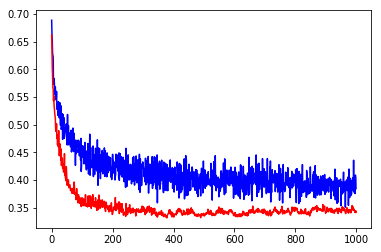

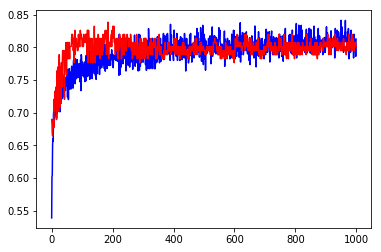

In [28]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [29]:
saveModel(model, run_name_acc)

## 3. Predict

In [30]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\statoil-iceberg-classifier-challenge\output\SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_001749_3560.csv


In [31]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.68916881]
 [ 0.22874725]]
(8424, 1)
[[ 0.68916881]
 [ 0.22874725]]


In [32]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.689169
1  4023181e    0.228747
(8424, 2)


In [33]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 20818.61 s
Done!


In [34]:
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_001749_3560
